In [89]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from boruta                  import BorutaPy
from sklearn.ensemble        import RandomForestRegressor
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.naive_bayes     import GaussianNB
from xgboost                 import XGBClassifier
from sklearn.metrics         import confusion_matrix, classification_report, accuracy_score
from tabulate                import tabulate
from IPython.core.display    import HTML
from IPython.display         import Image
warnings.filterwarnings("ignore")

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
     
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [3]:
df_raw = pd.read_csv('data/telecom_treino.csv')
teste = pd.read_csv('data/telecom_teste.csv') 

In [4]:
df_raw.head()

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [5]:
teste.head()

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,HI,101,area_code_510,no,no,0,70.9,123,12.05,211.9,73,18.01,236.0,73,10.62,10.6,3,2.86,3,no
1,2,MT,137,area_code_510,no,no,0,223.6,86,38.01,244.8,139,20.81,94.2,81,4.24,9.5,7,2.57,0,no
2,3,OH,103,area_code_408,no,yes,29,294.7,95,50.10,237.3,105,20.17,300.3,127,13.51,13.7,6,3.70,1,no
3,4,NM,99,area_code_415,no,no,0,216.8,123,36.86,126.4,88,10.74,220.6,82,9.93,15.7,2,4.24,1,no
4,5,SC,108,area_code_415,no,no,0,197.4,78,33.56,124.0,101,10.54,204.5,107,9.20,7.7,4,2.08,2,no


In [6]:
df_raw = df_raw.drop(['Unnamed: 0'], axis=1)
teste = teste.drop(['Unnamed: 0'], axis=1)

# 1.0 DESCRICAO DOS DADOS

In [7]:
df1 = pd.concat([df_raw, teste], ignore_index=True)

In [8]:
len(df1)

5000

In [9]:
df1.dtypes

state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
dtype: object

In [10]:
df1.isnull().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

In [11]:
df1['churn'].value_counts()

no     4293
yes     707
Name: churn, dtype: int64

## 1.1 Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include = ["int64", "float64"])
cat_attributes = df1.select_dtypes(include = ["object"])

### 1.1.1 Numerical Attributes

In [13]:
# Central Tendency -media, mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, max, min, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenete
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m. columns = ["attributes", "min", "max", "range", "mean", "median", "std", "skew", "kurtosis"]

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,account_length,1.0,243.00,242.00,100.258600,100.00,39.690590,0.109291,-0.101621
1,number_vmail_messages,0.0,52.00,52.00,7.755200,0.00,13.545039,1.350493,0.199127
2,total_day_minutes,0.0,351.50,351.50,180.288900,180.10,53.889309,-0.011731,-0.021294
3,total_day_calls,0.0,165.00,165.00,100.029400,100.00,19.829214,-0.084891,0.178568
4,total_day_charge,0.0,59.76,59.76,30.649668,30.62,9.161152,-0.011729,-0.021166
5,total_eve_minutes,0.0,363.70,363.70,200.636560,201.00,50.546254,-0.011018,0.051375
6,total_eve_calls,0.0,170.00,170.00,100.191000,100.00,19.824513,-0.020175,0.117363
7,total_eve_charge,0.0,30.91,30.91,17.054322,17.09,4.296414,-0.010990,0.051289
8,total_night_minutes,0.0,395.00,395.00,200.391620,200.40,50.522736,0.019325,0.082359
9,total_night_calls,0.0,175.00,175.00,99.919200,100.00,19.956690,0.002133,0.144438


<AxesSubplot:xlabel='account_length', ylabel='Density'>

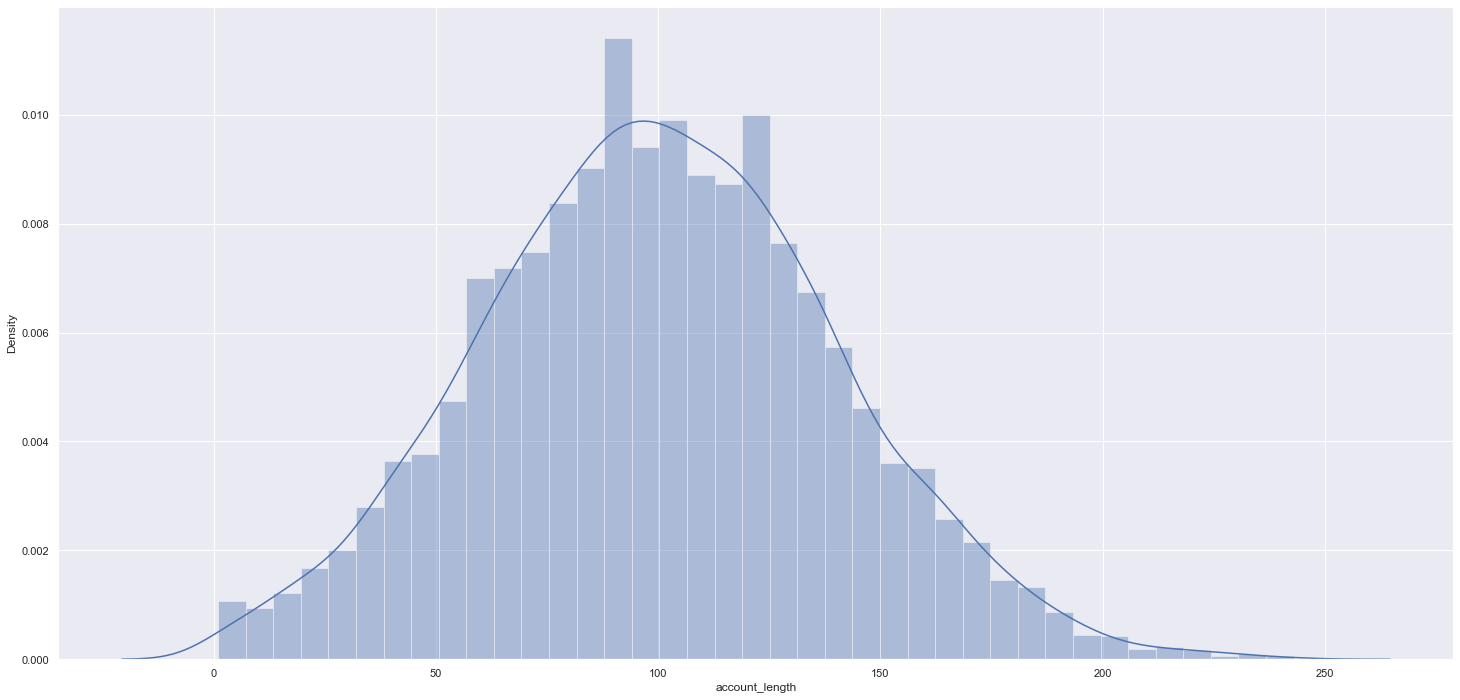

In [14]:
sns.distplot( df1["account_length"] )

<AxesSubplot:xlabel='number_customer_service_calls', ylabel='count'>

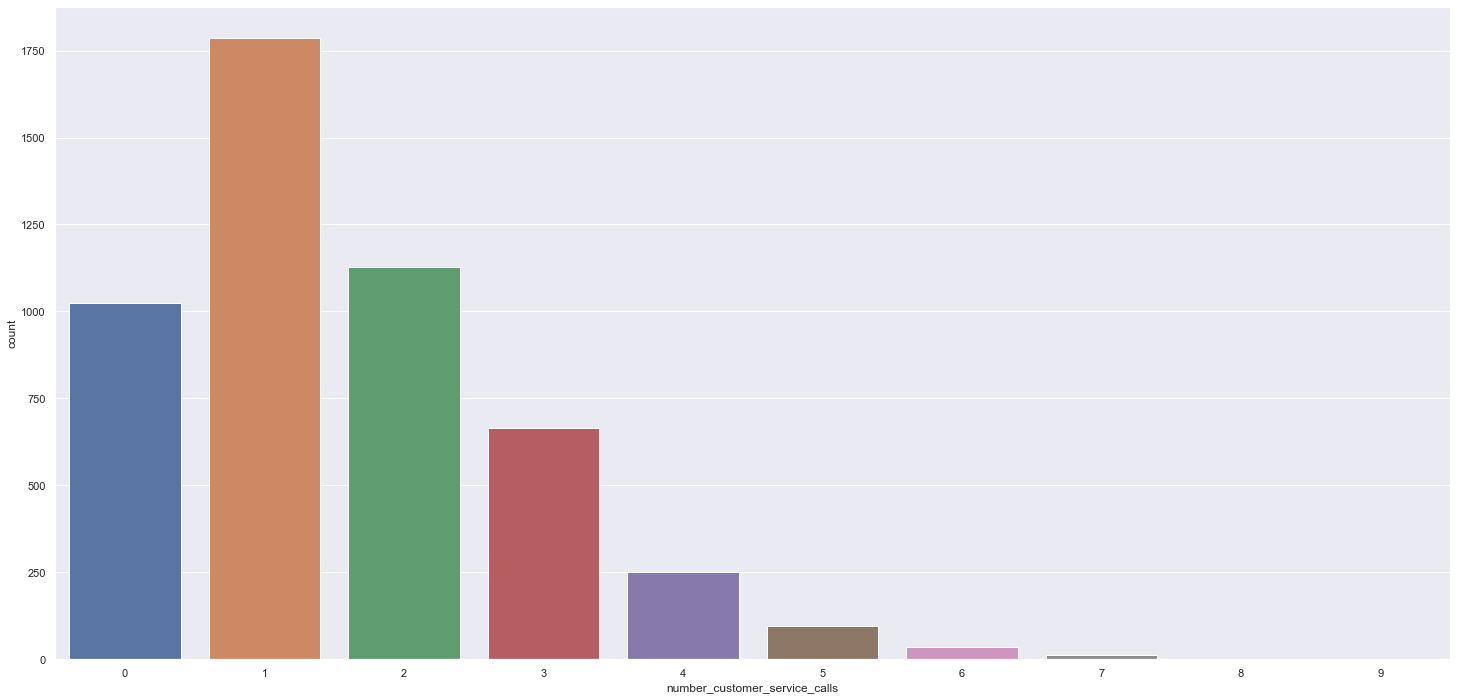

In [15]:
sns.countplot( df1["number_customer_service_calls"] )

### 1.2.2 Categorical Attribute

In [16]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state                 51
area_code              3
international_plan     2
voice_mail_plan        2
churn                  2
dtype: int64

<AxesSubplot:xlabel='churn', ylabel='number_customer_service_calls'>

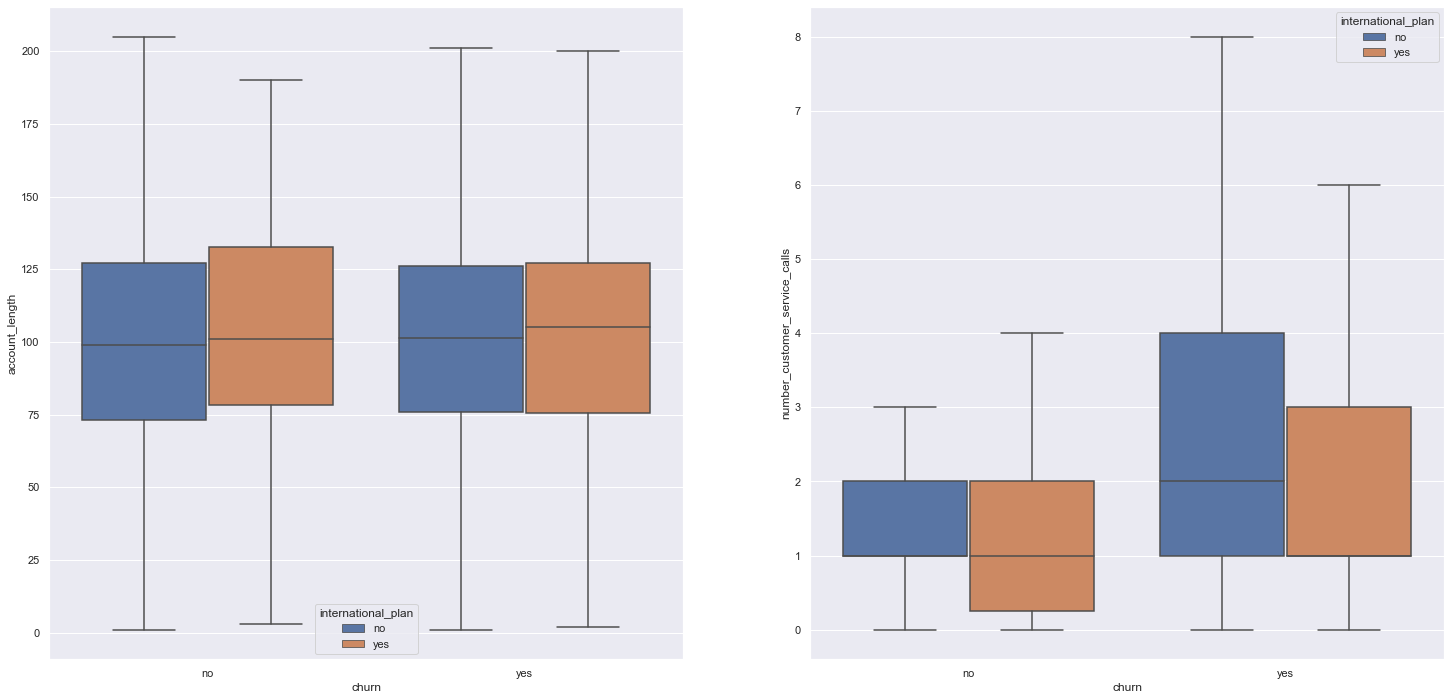

In [17]:
plt.subplot(1, 2, 1)
sns.boxplot( x="churn",y="account_length", data=df1, showfliers=False, hue='international_plan' )

plt.subplot(1, 2, 2)
sns.boxplot( x="churn",y="number_customer_service_calls", data=df1, showfliers=False, hue='international_plan' )


# 2.0  FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1 Mapa mental de Hipóteses

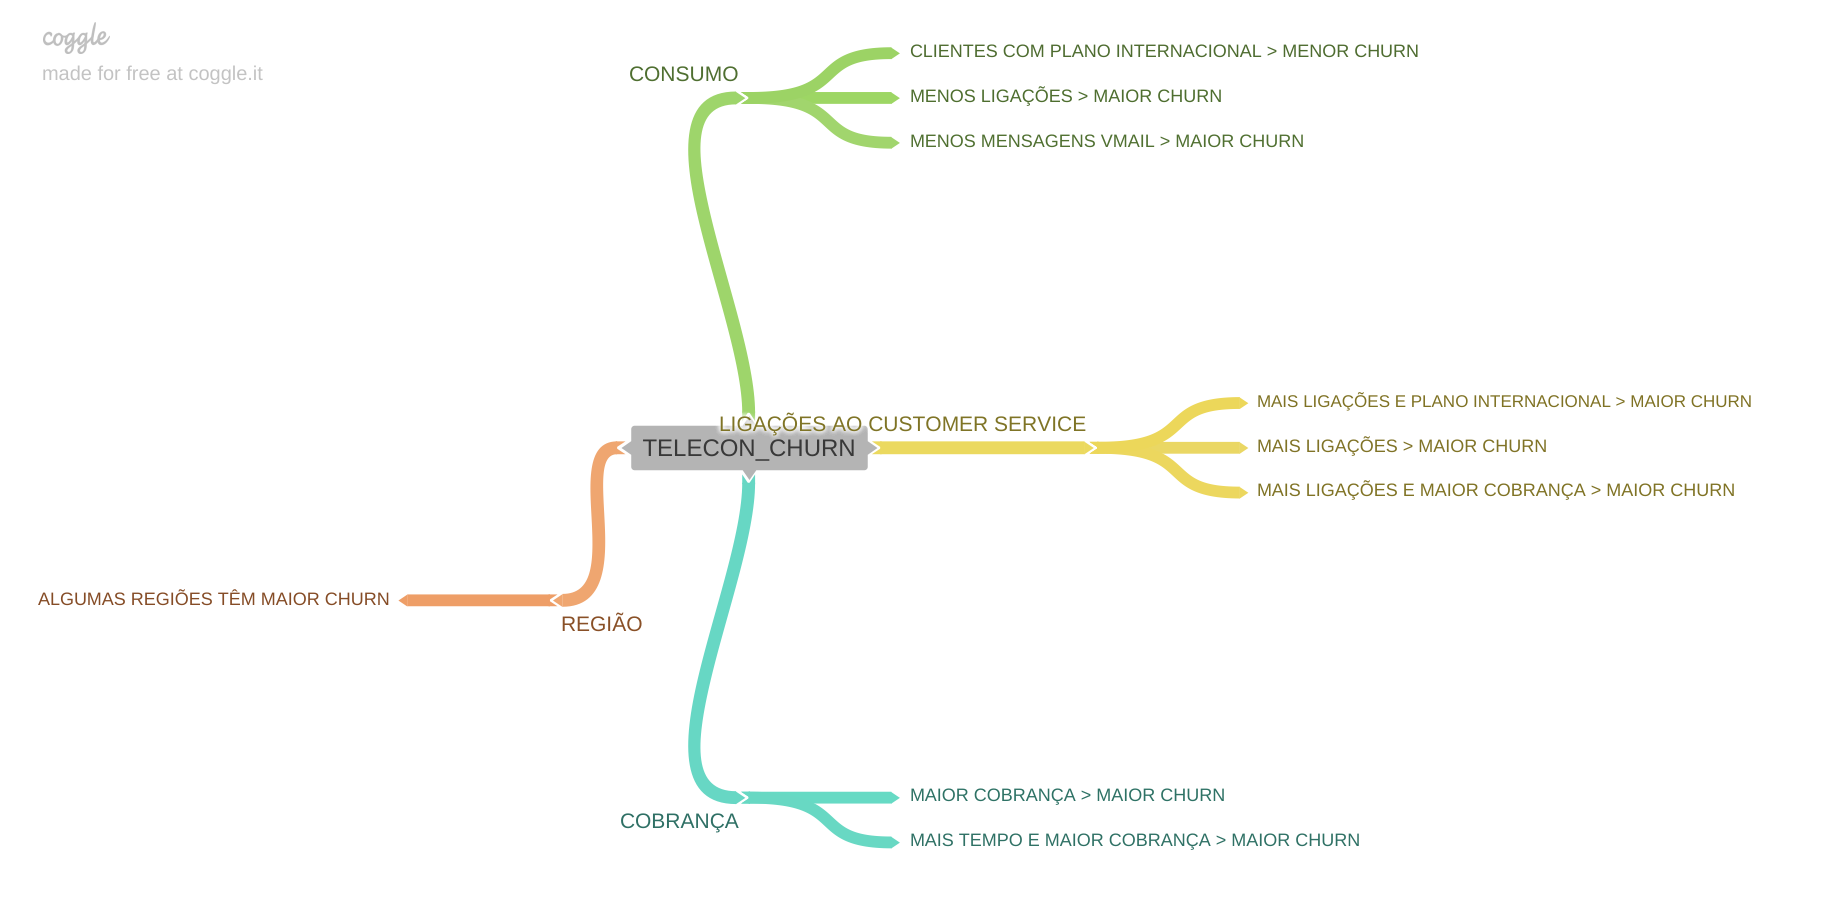

In [19]:
Image("img/TELECON_CHURN.png")

## 2.2 Feature Engineering

In [20]:
df2['total_minutes'] =  df2['total_day_minutes'] + df2['total_eve_minutes'] + df2['total_night_minutes']               
df2['total_calls'] = df2['total_day_calls'] + df2['total_eve_calls'] + df2['total_night_calls']                  
df2['total_charge'] = df2['total_day_charge'] + df2['total_eve_charge'] + df2['total_night_charge']

In [21]:
df2['tarifa_day'] = df2['total_day_charge']/df2['total_day_minutes']
df2['tarifa_eve'] = df2['total_eve_charge']/df2['total_eve_minutes']
df2['tarifa_night'] = df2['total_night_charge']/df2['total_night_minutes']
df2['tarifa_media'] = df2['total_charge']/df2['total_minutes']

In [22]:
df2.isnull().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
total_minutes                    0
total_calls                      0
total_charge                     0
tarifa_day                       2
tarifa_eve                       1
tarifa_night                     1
tarifa_media                     0
dtype: int64

In [23]:
df2 = df2.fillna(0)

In [24]:
aux = df2[['total_minutes', 'total_calls', 'total_charge', 'tarifa_day', 'tarifa_eve', 'tarifa_night']]

In [25]:
# Central Tendency -media, mediana
ct1 = pd.DataFrame(aux.apply(np.mean)).T
ct2 = pd.DataFrame(aux.apply(np.median)).T

# Dispersion - std, max, min, range, skew, kurtosis
d1 = pd.DataFrame(aux.apply(np.std)).T
d2 = pd.DataFrame(aux.apply(min)).T
d3 = pd.DataFrame(aux.apply(max)).T
d4 = pd.DataFrame(aux.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(aux.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(aux.apply(lambda x: x.kurtosis())).T

#concatenete
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m. columns = ["attributes", "min", "max", "range", "mean", "median", "std", "skew", "kurtosis"]

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,total_minutes,275.20,876.900000,601.700000,581.317080,581.850000,89.063040,0.009501,-0.035929
1,total_calls,188.00,410.000000,222.000000,300.139600,300.000000,34.205674,-0.017685,-0.147014
2,total_charge,19.98,92.560000,72.580000,56.721722,56.700000,10.337973,-0.005900,0.057091
3,tarifa_day,0.00,0.170513,0.170513,0.169935,0.170004,0.003399,-49.980314,2497.186450
4,tarifa_eve,0.00,0.085202,0.085202,0.084984,0.085000,0.001202,-70.690379,4998.086030
5,tarifa_night,0.00,0.045111,0.045111,0.044992,0.045000,0.000637,-70.639827,4993.319509


In [26]:
df2.loc[1, "international_plan"]

'no'

In [27]:
for n in range(len(df2)):
    
    if (df2.loc[n, "international_plan"]=='yes') & (df2.loc[n, "voice_mail_plan"]=='no'):
        df2.loc[n,'numero_de_planos'] = 1
    if (df2.loc[n, "international_plan"]=='no') & (df2.loc[n, "voice_mail_plan"]=='yes'):
        df2.loc[n,'numero_de_planos'] = 1
    if (df2.loc[n, "international_plan"]=='yes') & (df2.loc[n, "voice_mail_plan"]=='yes'):
        df2.loc[n,'numero_de_planos'] = 2
    if (df2.loc[n, "international_plan"]=='no') & (df2.loc[n, "voice_mail_plan"]=='no'):
        df2.loc[n,'numero_de_planos'] = 0

In [28]:
print('Número de clientes com os dois planos: ',len(df2[df2['numero_de_planos']==2]))
print('Número de clientes com um plano: ',len(df2[df2['numero_de_planos']==1]))
print('Número de clientes sem nenhum plano: ',len(df2[df2['numero_de_planos']==0]))

Número de clientes com os dois planos:  131
Número de clientes com um plano:  1534
Número de clientes sem nenhum plano:  3335


In [29]:
for n in range(len(df2)):
    if df2.loc[n, "number_vmail_messages"]==0:
        df2.loc[n,'usou_vmail'] = 'no'
    else:
        df2.loc[n,'usou_vmail'] = 'yes'

In [30]:
df2['usou_vmail'].value_counts(normalize=True)

no     0.7356
yes    0.2644
Name: usou_vmail, dtype: float64

In [31]:
for n in range(len(df2)):
    if df2.loc[n, "number_customer_service_calls"]==0:
        df2.loc[n,'ligou_customer_service'] = 'no'
    else:
        df2.loc[n,'ligou_customer_service'] = 'yes'

In [32]:
df2['ligou_customer_service'].value_counts(normalize=True)

yes    0.7954
no     0.2046
Name: ligou_customer_service, dtype: float64

In [33]:
df2["count_churn"] = df2["churn"].apply( lambda x: 0 if x=='no' else 1)

# 3.0 ANALISE EXPLORATORIA DOS DADOS

In [34]:
df3 = df2.copy()

In [35]:
df3.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_minutes,total_calls,total_charge,tarifa_day,tarifa_eve,tarifa_night,tarifa_media,numero_de_planos,usou_vmail,ligou_customer_service,count_churn
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no,707.2,300,72.86,0.170011,0.085005,0.044994,0.103026,1.0,yes,yes,0
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no,611.5,329,55.54,0.169988,0.085013,0.045008,0.090826,1.0,yes,yes,0
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no,527.2,328,59.00,0.170008,0.084983,0.045018,0.111912,0.0,no,no,0
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no,558.2,248,65.02,0.170007,0.084976,0.044997,0.116482,1.0,no,yes,0
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no,501.9,356,49.36,0.170006,0.085030,0.044997,0.098346,1.0,no,yes,0


## 3.1 Analise Univarida

### 3.1.1 Response variable

In [36]:
df3["churn"].value_counts(normalize=True)

no     0.8586
yes    0.1414
Name: churn, dtype: float64

<AxesSubplot:xlabel='churn', ylabel='count'>

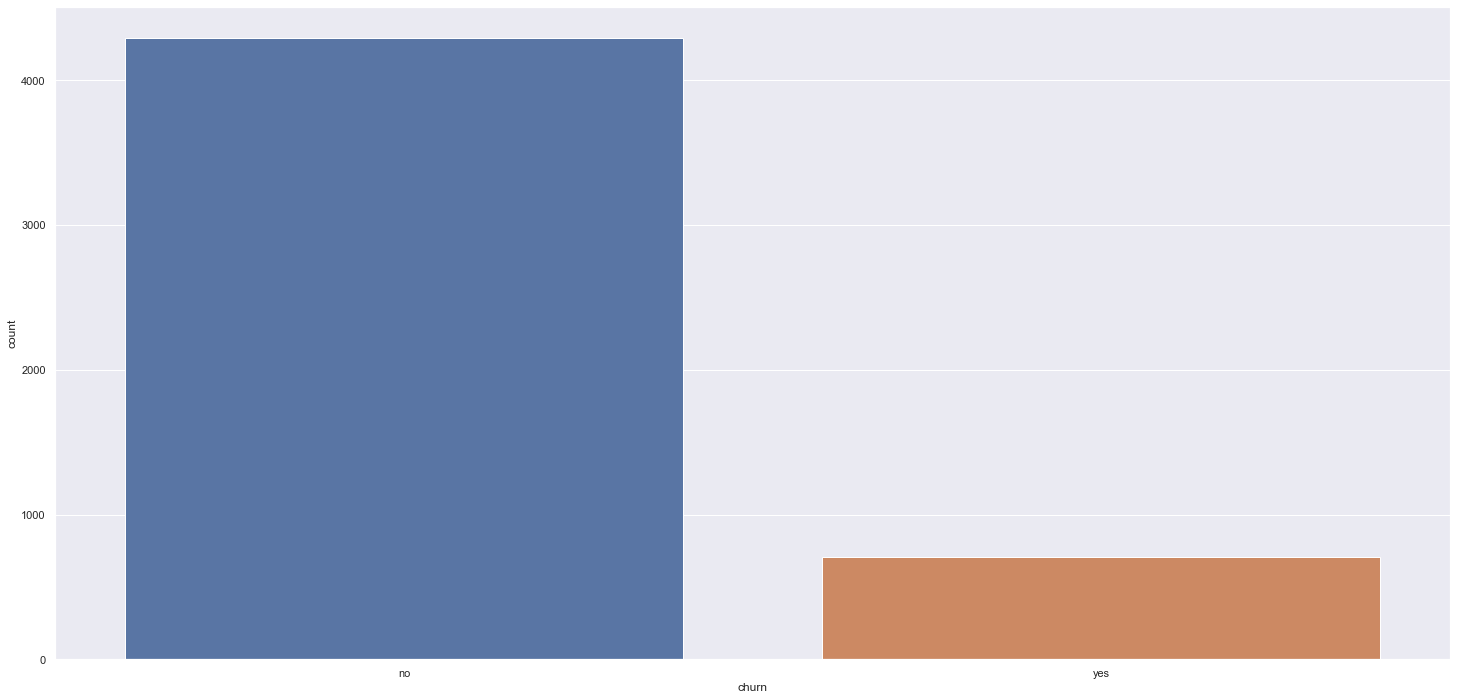

In [37]:
sns.countplot(df3["churn"])

### 3.1.2 Numerical variable

In [38]:
num_attributes = df3.select_dtypes(include = ["int64", "float64"])
cat_attributes = df3.select_dtypes(include = ["object"])

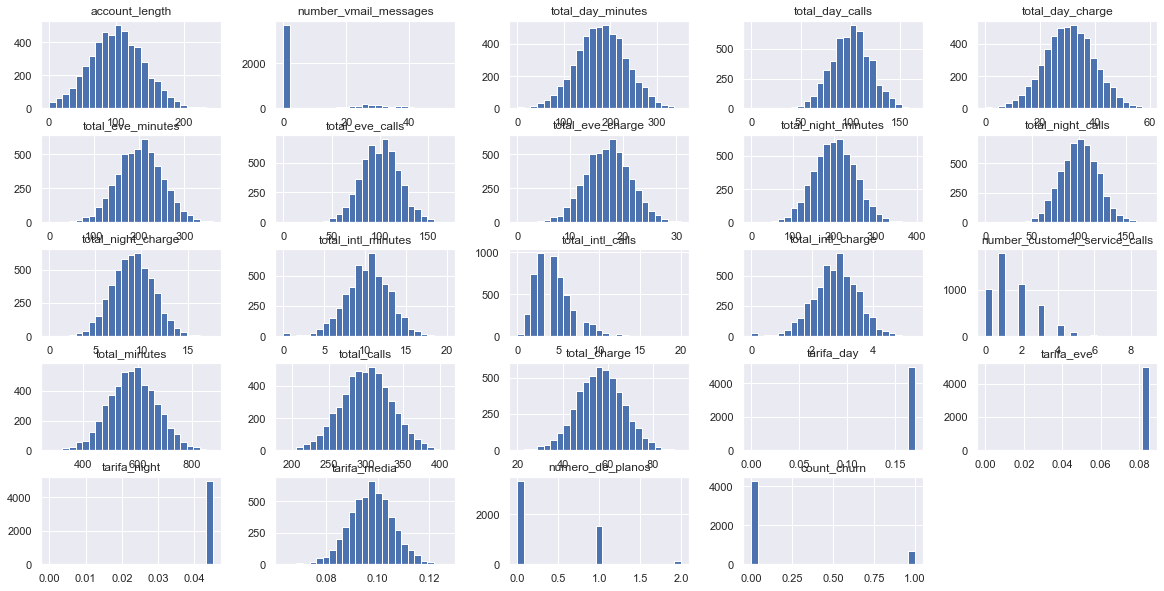

In [39]:
num_attributes.hist( bins=25 , figsize = (20,10));

### 3.1.3 Categorical Variable

In [40]:
cat_attributes.columns

Index(['state', 'area_code', 'international_plan', 'voice_mail_plan', 'churn',
       'usou_vmail', 'ligou_customer_service'],
      dtype='object')

In [41]:
df3['area_code'].value_counts()

area_code_415    2495
area_code_408    1259
area_code_510    1246
Name: area_code, dtype: int64

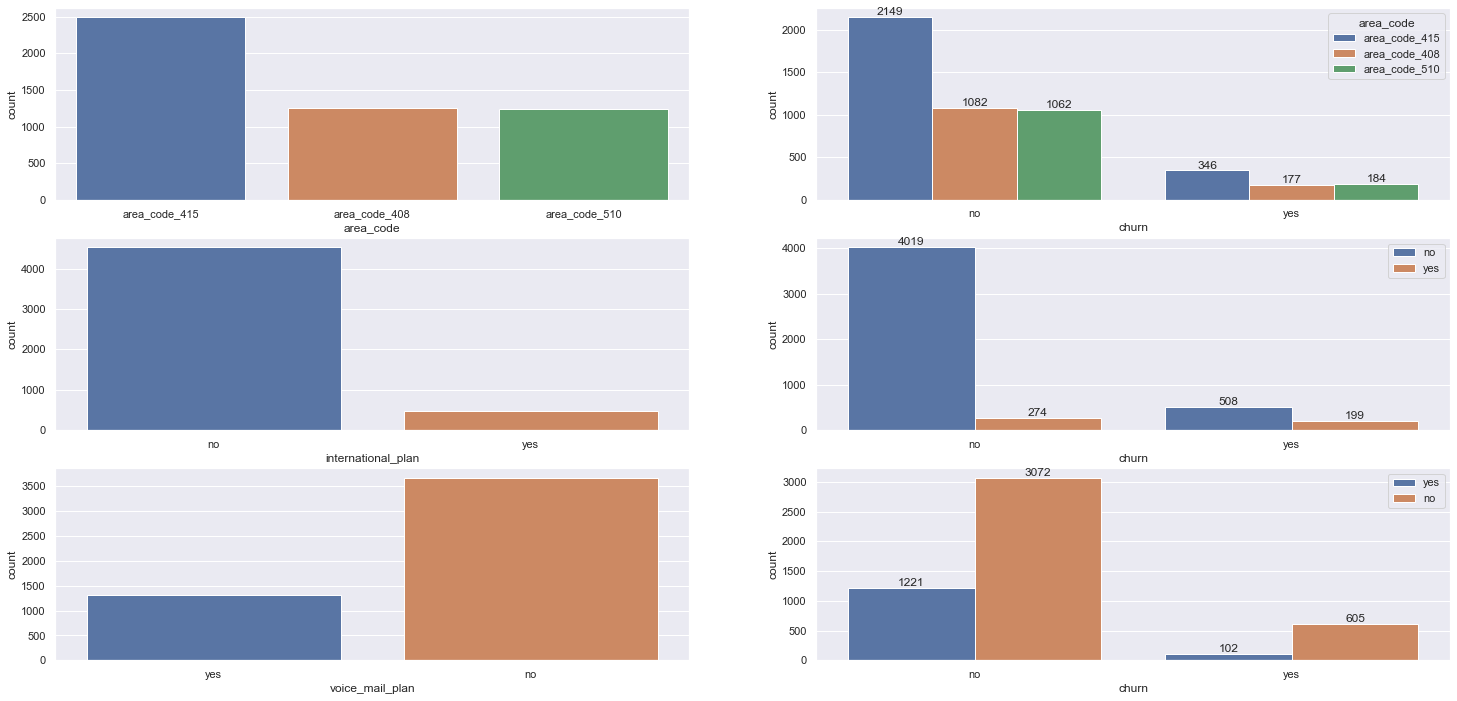

In [42]:
plt.subplot(3,2,1)
ax1 = sns.countplot( df3["area_code"] )

plt.subplot(3,2,2)
ax2 = sns.countplot( df3["churn"], hue=df3["area_code"])
ax2.bar_label(ax2.containers[0])
ax2.bar_label(ax2.containers[1])
ax2.bar_label(ax2.containers[2])

#store_type
plt.subplot(3,2,3)
ax3 = sns.countplot( df3["international_plan"] )


plt.subplot(3,2,4)
ax4 = sns.countplot( df3["churn"], hue=df3["international_plan"])
ax4.bar_label(ax4.containers[0])
ax4.bar_label(ax4.containers[1])
plt.legend()

#assortment	
plt.subplot(3,2,5)
ax5 = sns.countplot( df3["voice_mail_plan"] )


plt.subplot(3,2,6)
ax6 = sns.countplot( df3["churn"], hue=df3["voice_mail_plan"])
ax6.bar_label(ax6.containers[0])
ax6.bar_label(ax6.containers[1])
plt.legend()

In [43]:
a = df3[['state','churn']]
a['count'] = 1
pd.pivot_table(a, index='state', columns='churn', aggfunc=np.sum).T

state        AK   AL  AR  AZ  CA  CO  CT  DC  DE  FL  GA  HI  IA   ID  IL  IN  KS  KY  LA  MA  MD  ME  MI   MN  MO  MS  MT  NC  ND  NE  NH  NJ  NM  NV  NY   OH  OK  OR  PA  RI  SC  SD  TN  TX  UT   VA  VT  WA  WI   WV   WY
      churn                                                                                                                                                                                                                   
count no     67  111  76  80  38  85  83  79  79  78  73  81  61  105  81  84  81  84  75  86  81  84  85  105  81  82  78  79  78  82  83  84  81  73  94  101  74  96  69  92  75  73  75  90  96  112  91  74  98  136  104
      yes     5   13  16   9  14  11  16   9  15  12  10   5   8   14   7  14  18  15   7  17  21  19  18   20  12  17  21  12  10   6  12  28  10  17  20   15  16  18   8   7  16  12  14  26  16    6  10  24   8   22   11

## 3.2 Análise Bivariada

### H1. Clientes com mais planos tem menor representatividade no churn
**FALSO** Clientes com apenas voice mail plan são menos propensos a ralizar churn, o contrário acontece com os clientes com internacional plan, quando o cliente tem os dois planos ele também está mais propenso ao churn

In [44]:
dois_planos = pd.DataFrame(df3[df3['numero_de_planos']==2]['churn'].value_counts(normalize=True)).reset_index()
um_plano = pd.DataFrame(df3[df3['numero_de_planos']==1]['churn'].value_counts(normalize=True)).reset_index()
nenhum_plano = pd.DataFrame(df3[df3['numero_de_planos']==0]['churn'].value_counts(normalize=True)).reset_index()
aux1 = nenhum_plano.merge(um_plano, on='index', suffixes=('_nenhum_plano', '_um_plano')).\
merge(dois_planos, on='index').rename(columns={"churn": "churn_dois_planos", 'index': 'churn'})

In [45]:
aux1

,churn,churn_nenhum_plano,churn_um_plano,churn_dois_planos
0,no,0.864468,0.863755,0.648855
1,yes,0.135532,0.136245,0.351145


In [46]:
a= pd.DataFrame(df3.groupby("voice_mail_plan")['count_churn'].sum()).reset_index()
b= pd.DataFrame(df3["voice_mail_plan"].value_counts()).reset_index()
c= a.merge(b, right_on='index', left_on="voice_mail_plan",suffixes=('', '_count')).drop(['index'], axis=1)
c['porcentagem_churn_voice_mail_plan']= c['count_churn']/c['voice_mail_plan_count'] 
c

,voice_mail_plan,count_churn,voice_mail_plan_count,porcentagem_churn_voice_mail_plan
0,no,605,3677,0.164536
1,yes,102,1323,0.077098


In [47]:
a= pd.DataFrame(df3.groupby('international_plan')['count_churn'].sum()).reset_index()
b= pd.DataFrame(df3['international_plan'].value_counts()).reset_index()
c= a.merge(b, right_on='index', left_on='international_plan',suffixes=('', '_count')).drop(['index'], axis=1)
c['porcentagem_churn_int_plan']= c['count_churn']/c['international_plan_count'] 
c

,international_plan,count_churn,international_plan_count,porcentagem_churn_int_plan
0,no,508,4527,0.112216
1,yes,199,473,0.420719


### H2. O consumo influencia na probabilidade de churn
**VERDADEIRO** Os clientes que realizaram o churn têm mais minutos em chamada do que os clientes ativos, porém vemos que os clientes que não usam o vmail (ou quanto menos usam o vmail) estão mais propensos ao churn

In [48]:
df3.groupby('churn')['number_vmail_messages'].mean()

churn
no     8.291870
yes    4.496464
Name: number_vmail_messages, dtype: float64

<AxesSubplot:xlabel='churn', ylabel='number_vmail_messages'>

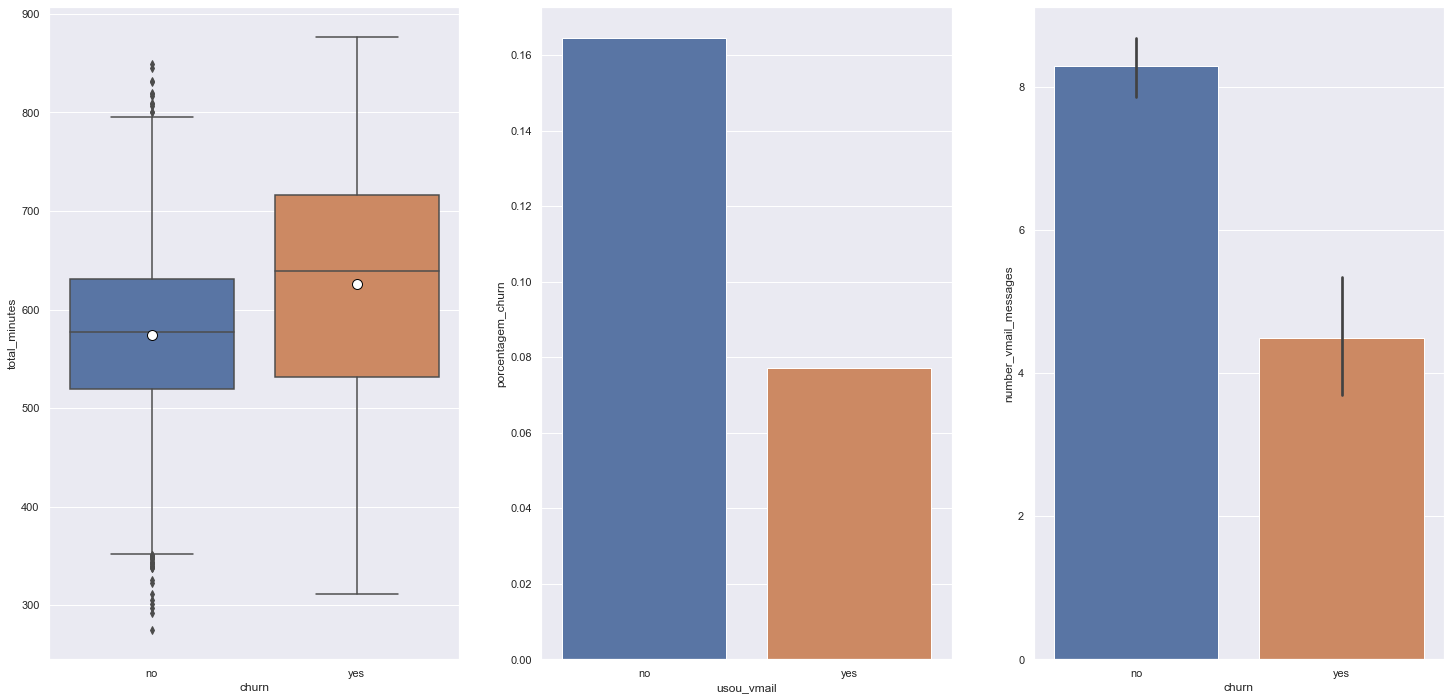

In [49]:
aux1 = df3[['churn', 'total_minutes']]
aux2 = df3[['usou_vmail','count_churn']].groupby("usou_vmail").sum().reset_index()
aux3 = pd.DataFrame(df3['usou_vmail'].value_counts()).reset_index()
aux4 = aux2.merge(aux3, right_on='index', left_on='usou_vmail',suffixes=('', '_count')).drop(['index'], axis=1)
aux4['porcentagem_churn']=aux4['count_churn']/aux4['usou_vmail_count']
plt.subplot(1,3,1)
sns.boxplot( x="churn",y='total_minutes', data=aux1, showmeans=True, meanprops={"marker":"o", 
                                                                                "markerfacecolor":"white", 
                                                                                "markeredgecolor":"black", 
                                                                                "markersize":"10"})

plt.subplot(1,3,2)
sns.barplot(x='usou_vmail',y='porcentagem_churn',data=aux4)

plt.subplot(1,3,3)
sns.barplot(x='churn',y='number_vmail_messages',data=df3)

### H3. Clientes que pagam mais estão mais propensos ao churn
**VERDADEIRO** Clientes que realizaram churn tinham maiores despesas 

In [50]:
aux1 = df3[['account_length','total_charge','churn']]
aux1['charge_per_day'] = aux1['total_charge']/aux1['account_length']

In [51]:
aux1.groupby('churn')['total_charge', 'charge_per_day'].mean()

,total_charge,charge_per_day
churn,,
no,55.751740,0.893988
yes,62.611584,0.900129


<AxesSubplot:xlabel='churn', ylabel='charge_per_day'>

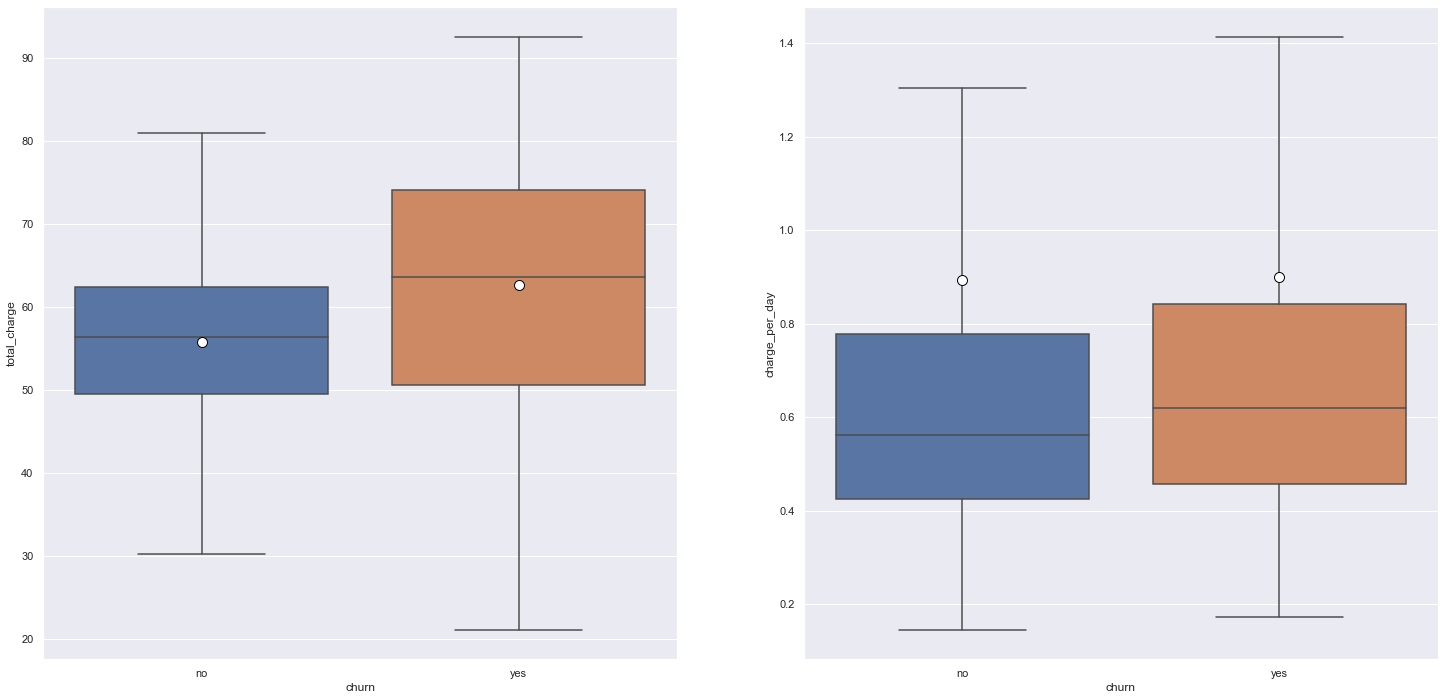

In [52]:
plt.subplot(1,2,1)
sns.boxplot( x="churn",y='total_charge', data=aux1, showmeans=True, showfliers=False, meanprops={"marker":"o", 
                                                                                "markerfacecolor":"white", 
                                                                                "markeredgecolor":"black", 
                                                                                "markersize":"10"})

plt.subplot(1,2,2)
sns.boxplot( x="churn",y='charge_per_day', data=aux1, showmeans=True, showfliers=False, meanprops={"marker":"o", 
                                                                                "markerfacecolor":"white", 
                                                                                "markeredgecolor":"black", 
                                                                                "markersize":"10"})

### H4. Clientes com tarifas maiores mais propensos ao churn
**VERDADEIRO** Clientes que realizaram churn pagam tarifas maiores

In [53]:
df3.groupby('churn')['tarifa_media'].mean()

churn
no     0.097085
yes    0.099485
Name: tarifa_media, dtype: float64

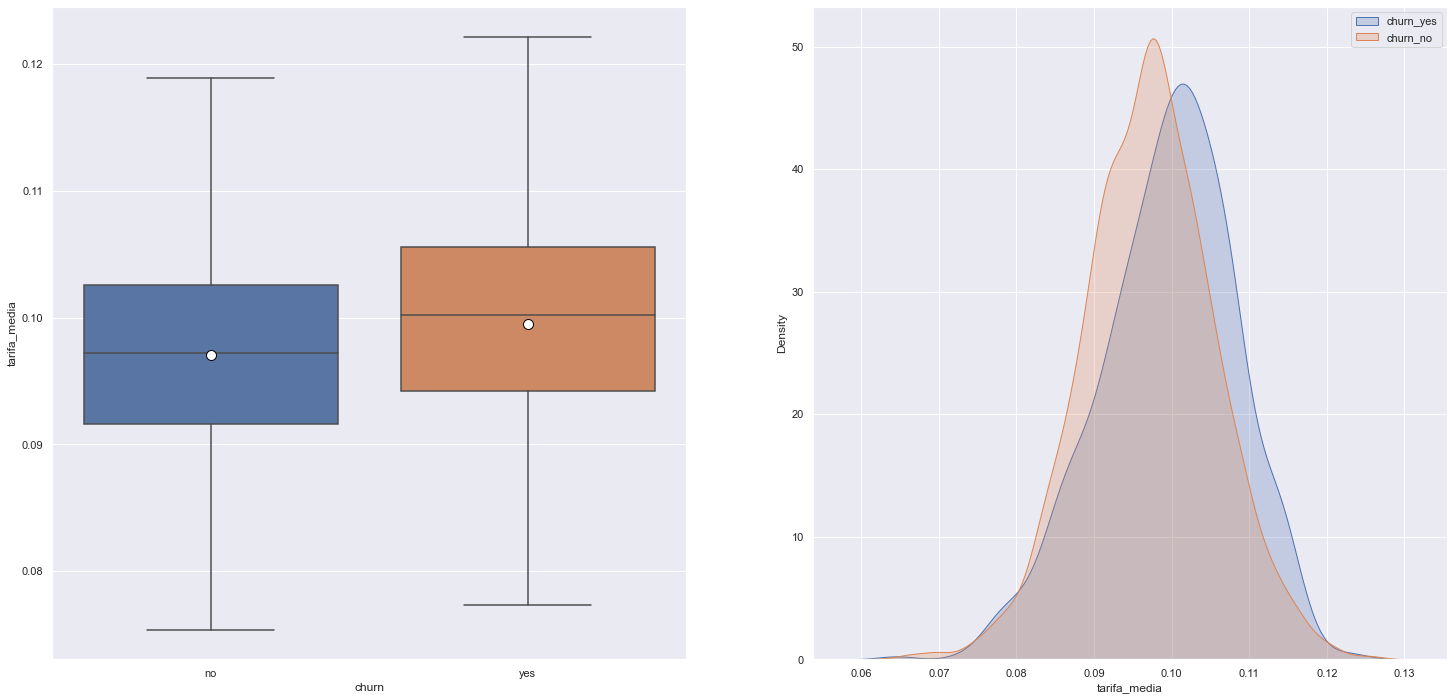

In [54]:
plt.subplot(1,2,1)
sns.boxplot( x="churn",y='tarifa_media', data=df3, showmeans=True, showfliers=False, meanprops={"marker":"o", 
                                                                                "markerfacecolor":"white", 
                                                                                "markeredgecolor":"black", 
                                                                                "markersize":"10"})

plt.subplot(1,2,2)
sns.kdeplot( df3[df3["churn"] == "yes"]["tarifa_media"], label = "churn_yes", shade = True)
sns.kdeplot( df3[df3["churn"] == "no"]["tarifa_media"], label = "churn_no", shade = True)
plt.legend()

### H5. Clientes com menos ligações são mais propensos ao churn
**FALSO** O número de ligações não demosntra ter um impacto significativo no número de churns, com exceção, talvez, entre os clientes sem nenhum plano adicionl, porém ainda com valores pouco conclusivos

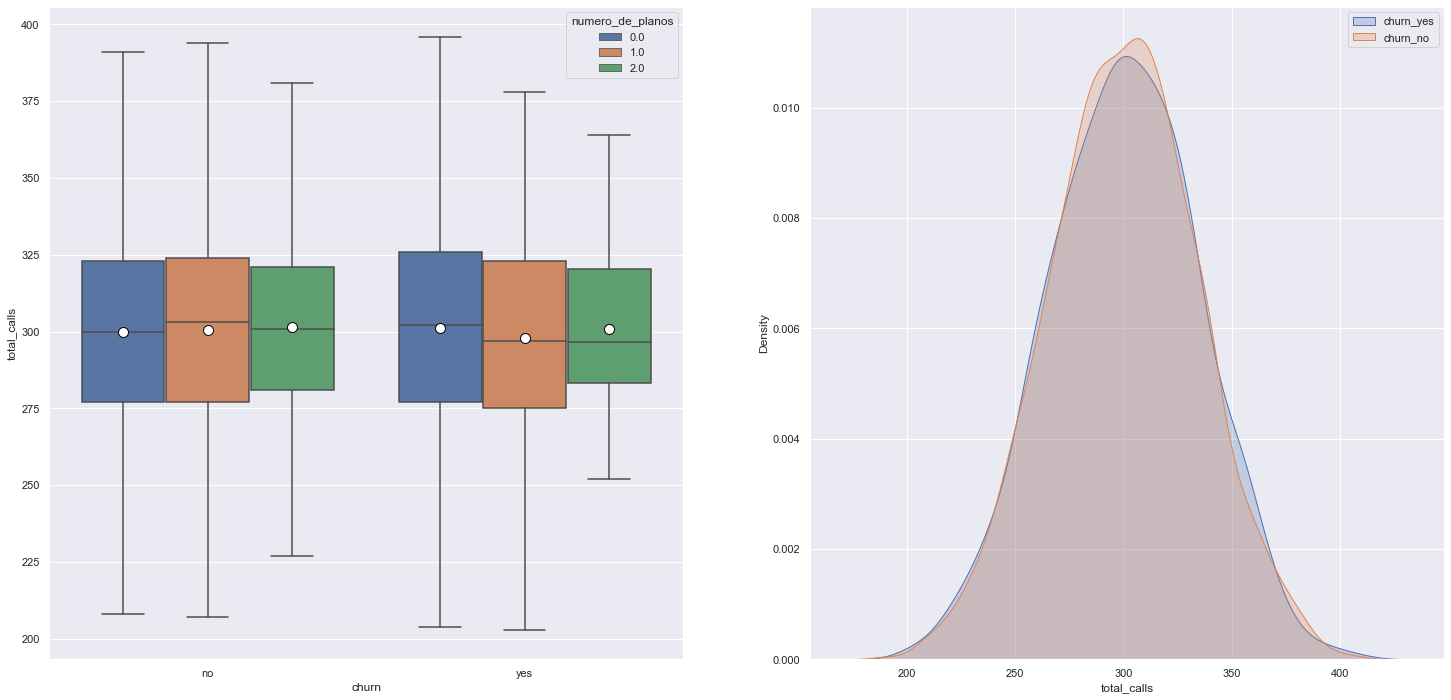

In [55]:
plt.subplot(1,2,1)
sns.boxplot( x="churn",y='total_calls', data=df3, showmeans=True, hue='numero_de_planos', showfliers=False, meanprops={"marker":"o", 
                                                                                "markerfacecolor":"white", 
                                                                                "markeredgecolor":"black", 
                                                                                "markersize":"10"})

plt.subplot(1,2,2)
sns.kdeplot( df3[df3["churn"] == "yes"]["total_calls"], label = "churn_yes", shade = True)
sns.kdeplot( df3[df3["churn"] == "no"]["total_calls"], label = "churn_no", shade = True)
plt.legend()

### H6. Clientes com mais ligações pro customer service são mais propensos ao churn
**VERDADEIRO** Usários que realizaram o churn fazem mais ligações ao customer service

In [56]:
aux1 = df3[df3.ligou_customer_service == 'yes']
aux2 = df3[df3.ligou_customer_service == 'no']

Text(0.5, 1.0, 'Somente Usuários que ligaram')

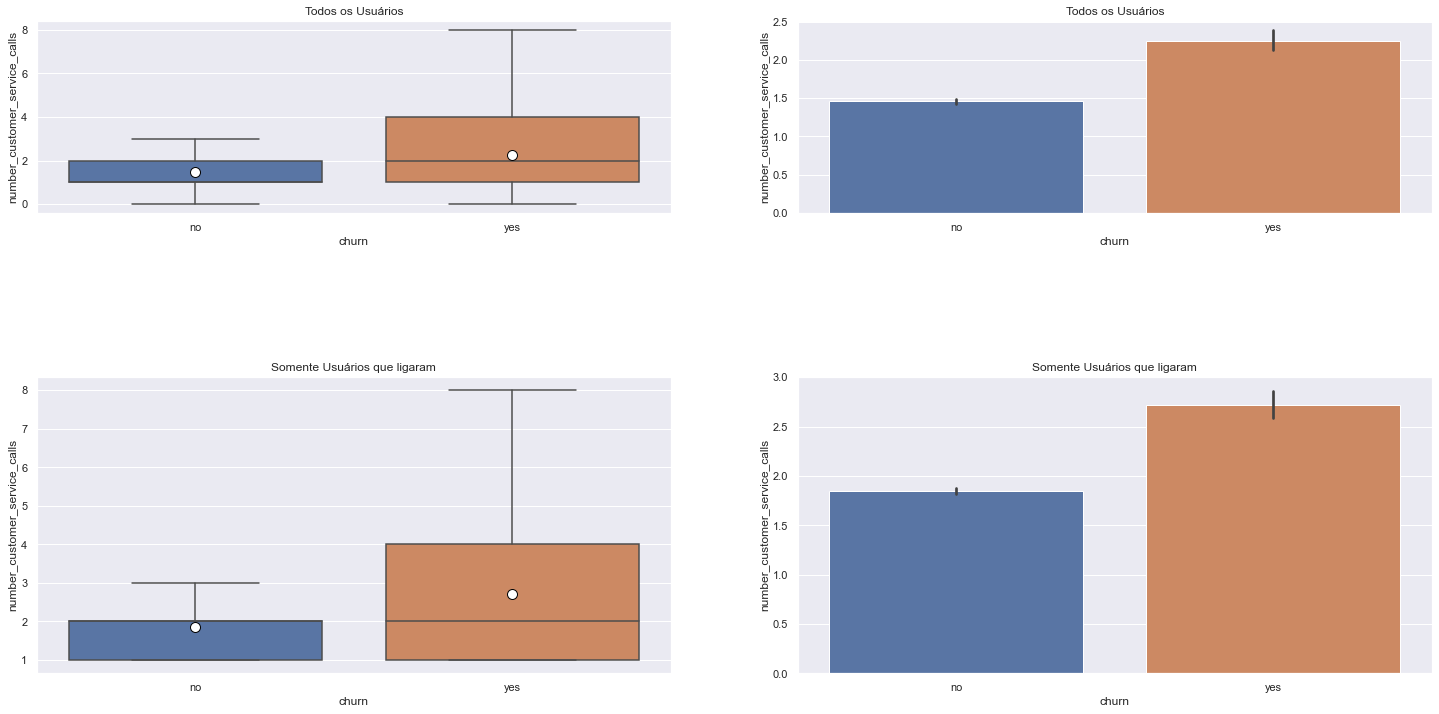

In [57]:
plt.subplot(3,2,1)
sns.boxplot( x="churn",y='number_customer_service_calls', data=df3, showmeans=True, showfliers=False, meanprops={"marker":"o", 
                                                                                "markerfacecolor":"white", 
                                                                                "markeredgecolor":"black", 
                                                                                "markersize":"10"}).set_title('Todos os Usuários')

plt.subplot(3,2,2)
sns.barplot(x='churn', y='number_customer_service_calls', data=df3).set_title('Todos os Usuários')

plt.subplot(2,2,3)
sns.boxplot(x="churn",y='number_customer_service_calls', data=aux1, showmeans=True, showfliers=False, meanprops={"marker":"o", 
                                                                                "markerfacecolor":"white", 
                                                                                "markeredgecolor":"black", 
                                                                                "markersize":"10"}).set_title('Somente Usuários que ligaram')

plt.subplot(2,2,4)
sns.barplot(x='churn', y='number_customer_service_calls', data=aux1).set_title('Somente Usuários que ligaram')

### 3.2.1 Resumo das Hipóteses

In [58]:
tab = [["Hipotese", "Conclusao", "Relevancia"],
      ["H1", "Falsa","Media"],
      ["H2", "Verdade","Forte"],
      ["H3", "Verdade","Media"],
      ["H4", "Verdade","Media"],
      ["H5", "Falso","Forte"],
      ["H6", "Verdade","Forte"]]
tabela_de_relevancia = tabulate(tab, headers= 'firstrow' )
print( tabela_de_relevancia )

Hipotese    Conclusao    Relevancia
----------  -----------  ------------
H1          Falsa        Media
H2          Verdade      Forte
H3          Verdade      Media
H4          Verdade      Media
H5          Falso        Forte
H6          Verdade      Forte


### 3.2.2 Colunas Fortes

In [59]:
cols_importantes = ['number_customer_service_calls', 
                    'total_calls',
                    'tarifa_media',
                    'account_length',
                    'total_charge',
                    'number_vmail_messages',
                    'usou_vmail',
                    'voice_mail_plan',
                    'international_plan']

# 4.0 Feature Selection

In [60]:
df4 = df3.copy()

## 4.1 Data Preparation

### 4.1.1 Rescaling

In [61]:
rs = RobustScaler()
mms = MinMaxScaler()

df4['number_vmail_messages'] = rs.fit_transform(df4[['number_vmail_messages']].values)
pickle.dump(rs, open('parameter/number_vmail_messages_scaler.pkl', 'wb'))

col_scaller = ['account_length',
           'total_day_minutes',
           'total_day_minutes',
           'total_day_calls',
           'total_day_charge',
           'total_eve_minutes',
           'total_eve_calls',
           'total_eve_charge',
           'total_night_minutes',
           'total_night_calls',
           'total_night_charge',
           'total_intl_minutes',
           'total_intl_calls',
           'total_intl_charge',
           'number_customer_service_calls',
           'total_minutes',
           'total_calls',
           'total_charge',
           'tarifa_day',
           'tarifa_eve',
           'tarifa_night',
           'tarifa_media',
           'numero_de_planos']

df4[col_scaller] = mms.fit_transform(df4[col_scaller].values)
pickle.dump(mms, open('parameter/mms_scaller.pkl', 'wb'))

### 4.1.2 Encoding

In [62]:
 #Label Encoding
le = LabelEncoder()
df4['state'] = le.fit_transform(df4['state'])
pickle.dump(le, open('parameter/state_scaler.pkl', 'wb'))

df4['area_code'] = le.fit_transform(df4['area_code'])
pickle.dump(le, open('parameter/area_code_scaler.pkl', 'wb'))


#Ordinal Encoding
yes_no_dict = {'yes' : 1, 'no' : 0}
df4['international_plan'] = df4['international_plan'].map(yes_no_dict)
df4['voice_mail_plan'] = df4['voice_mail_plan'].map(yes_no_dict)
df4['usou_vmail'] = df4['usou_vmail'].map(yes_no_dict)
df4['ligou_customer_service'] = df4['ligou_customer_service'].map(yes_no_dict)
df4['churn'] = df4['churn'].map(yes_no_dict)

df4 = df4.drop('count_churn', axis=1)

In [63]:
df4.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_minutes,total_calls,total_charge,tarifa_day,tarifa_eve,tarifa_night,tarifa_media,numero_de_planos,usou_vmail,ligou_customer_service
0,16,0.524793,1,0,1,1.470588,0.754196,0.666667,0.754183,0.542755,0.582353,0.542866,0.619494,0.520000,0.619584,0.500,0.15,0.500000,0.111111,0,0.717966,0.504505,0.728575,0.997059,0.997691,0.997401,0.622731,0.5,1,1
1,35,0.438017,1,0,1,1.529412,0.459744,0.745455,0.459672,0.537531,0.605882,0.537690,0.644051,0.588571,0.644344,0.685,0.15,0.685185,0.111111,0,0.558916,0.635135,0.489942,0.996920,0.997782,0.997711,0.431228,0.5,1,1
2,31,0.561983,1,0,0,0.000000,0.692461,0.690909,0.692436,0.333242,0.647059,0.333225,0.411646,0.594286,0.411930,0.610,0.25,0.609259,0.000000,0,0.418813,0.630631,0.537614,0.997041,0.997438,0.997946,0.762211,0.0,0,0
3,35,0.342975,0,1,0,0.000000,0.851778,0.430303,0.851740,0.170195,0.517647,0.170171,0.498481,0.508571,0.498593,0.330,0.35,0.329630,0.222222,0,0.470334,0.270270,0.620557,0.997032,0.997347,0.997481,0.833938,0.5,0,1
4,36,0.305785,1,1,0,0.000000,0.474253,0.684848,0.474230,0.407754,0.717647,0.407959,0.473165,0.691429,0.473270,0.505,0.15,0.505556,0.333333,0,0.376766,0.756757,0.404795,0.997028,0.997988,0.997478,0.549274,0.5,0,1


## 4.2 Boruta as Feature Selector

In [64]:
X = df4.drop(['churn'], axis = 1)
Y = df4['churn']

In [65]:
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size = 0.3,random_state=42)

In [67]:
#x_treino_n = X_treino.values
#y_treino_n = Y_treino.values.ravel()

## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs = -1 )


## define Boruta
#boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit(x_treino_n, y_treino_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	20


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	20


### 4.2.1 Best Features from Boruta

In [68]:
#cols_selected = boruta.support_.tolist()

## best features
#x_treino_fs = X_treino
#cols_selected_boruta = x_treino_fs.iloc[:, cols_selected].columns.to_list()

##not selected Boruta
#cols_not_selected_boruta = list (np.setdiff1d(x_treino_fs.columns, cols_selected_boruta))

In [69]:
#cols_selected_boruta

['international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 'total_charge',
 'usou_vmail']

In [70]:
cols_selected_boruta = ['international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'number_customer_service_calls',
 'total_charge',
 'usou_vmail']

In [71]:
## Comparando as colunas selecionadas pelo método Boruta e escolhidas na EDA vamos decidir pelo seguinte conjunto de colunas
cols_final = ['international_plan',
              'voice_mail_plan',
              'number_vmail_messages',
              'total_calls',
              'total_charge',
              'total_intl_calls',
              'total_intl_charge',
              'number_customer_service_calls',
              'usou_vmail']

In [72]:
cols_final_full = cols_final.copy()
cols_final_full.extend(['churn'])

# 5.0 MACHINE LEARNING MODELING

In [73]:
df5 = df4.copy()

In [74]:
X_treino = X_treino[cols_final]
X_teste = X_teste[cols_final]

## 5.1 Regressão Logística

In [77]:
# Criando o objeto logistic regression 
modelo = LogisticRegression()

# Treinando o modelo com dados de treino e checando o score
modelo.fit(X_treino, Y_treino)
modelo.score(X_treino, Y_treino)

# Previsões
previsoes_logisticregression = modelo.predict(X_teste)

Coefficient: 
 [[ 2.00131468 -0.82788358  0.38693606  0.04097238  4.88556366 -1.20913569
   1.32236917  4.13015681 -0.82788358]]
Intercept: 
 [-5.76388078]


In [78]:
cm = confusion_matrix(Y_teste, previsoes_logisticregression)
report = classification_report(Y_teste, previsoes_logisticregression)
print(cm)
print(report)
accuracy_score(Y_teste, previsoes_logisticregression)

[[1263   30]
 [ 156   51]]
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1293
           1       0.63      0.25      0.35       207

    accuracy                           0.88      1500
   macro avg       0.76      0.61      0.64      1500
weighted avg       0.85      0.88      0.85      1500



0.876

## 5.2 Random Forest Classifier

In [82]:
modelo = RandomForestClassifier(n_estimators=100,criterion = 'entropy', random_state = 42, n_jobs=-1)

# Treinando o modelo com dados de treino 
modelo.fit(X_treino, Y_treino)

# Previsões
previsoes_randomforest = modelo.predict(X_teste)

In [83]:
cm = confusion_matrix(Y_teste, previsoes_randomforest)
report = classification_report(Y_teste, previsoes_randomforest)
print(cm)
print(report)
accuracy_score(Y_teste, previsoes_randomforest)

[[1288    5]
 [  31  176]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1293
           1       0.97      0.85      0.91       207

    accuracy                           0.98      1500
   macro avg       0.97      0.92      0.95      1500
weighted avg       0.98      0.98      0.98      1500



0.976

## 5.3 K-Nearest Neighbors

In [86]:
# Criando o objeto de classificação KNeighbors  
KNeighborsClassifier() 

# Treinando o modelo com dados de treino 
modelo.fit(X_treino, Y_treino)

# Previsões
previsoes_knn = modelo.predict(X_teste)

In [87]:
cm = confusion_matrix(Y_teste, previsoes_knn)
report = classification_report(Y_teste, previsoes_knn)
print(cm)
print(report)
accuracy_score(Y_teste, previsoes_knn)

[[1288    5]
 [  31  176]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1293
           1       0.97      0.85      0.91       207

    accuracy                           0.98      1500
   macro avg       0.97      0.92      0.95      1500
weighted avg       0.98      0.98      0.98      1500



0.976

## 5.4 Naive Bayes

In [90]:
# Criando o objeto GaussianNB
modelo = GaussianNB() 

# Treinando o modelo com dados de treino
modelo.fit(X_treino, Y_treino)

# Previsões
previsoes_naivebayes = modelo.predict(X_teste)

In [91]:
cm = confusion_matrix(Y_teste, previsoes_naivebayes)
report = classification_report(Y_teste, previsoes_naivebayes)
print(cm)
print(report)
accuracy_score(Y_teste, previsoes_naivebayes)

[[1196   97]
 [ 109   98]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1293
           1       0.50      0.47      0.49       207

    accuracy                           0.86      1500
   macro avg       0.71      0.70      0.70      1500
weighted avg       0.86      0.86      0.86      1500



0.8626666666666667

## 5.5 XGBoost Classifier

In [94]:
# Criando o objeto XGBClassifier
modelo = XGBClassifier()

# Treinando o modelo com dados de treino
modelo.fit(X_treino, Y_treino)

# Previsões
previsoes_XGB = modelo.predict(X_teste)

[21:25:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [95]:
cm = confusion_matrix(Y_teste, previsoes_XGB)
report = classification_report(Y_teste, previsoes_XGB)
print(cm)
print(report)
accuracy_score(Y_teste, previsoes_XGB)

[[1289    4]
 [  30  177]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1293
           1       0.98      0.86      0.91       207

    accuracy                           0.98      1500
   macro avg       0.98      0.93      0.95      1500
weighted avg       0.98      0.98      0.98      1500



0.9773333333333334